In [126]:
import numpy as np
import copy
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras  #v. 2.9.0
import os
import pandas as pd
from matplotlib import pyplot as plt
from numpy.random import seed
np.random.seed(2095)

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
#from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix

import warnings
warnings.filterwarnings("ignore")



# Reading and Exploring the dataframe

In [127]:
#### --------------------------------------------   COMMENT IT WHEN USING DATABRICKS   ---------------------------------

#reading the csv file (locally)
data = pd.read_csv('CardiacPrediction_csv.csv')

In [128]:
#### --------------------------------------------   UNCOMMENT IT WHEN USING DATABRICKS   ---------------------------------
#Reading csv file in databricks

# # File location and type 
# file_location = "/FileStore/tables/CardiacPrediction_csv.csv"
# file_type = "csv"

# # CSV options
# infer_schema = "false"
# first_row_is_header = "true"
# delimiter = ","

# # The applied options are for CSV files. For other file types, these will be ignored.
# df = spark.read.format(file_type) \
#   .option("inferSchema", infer_schema) \
#   .option("header", first_row_is_header) \
#   .option("sep", delimiter) \
#   .load(file_location)

# display(df)

In [129]:
#### --------------------------------------------   UNCOMMENT IT WHEN USING DATABRICKS   ---------------------------------

#dataframe 'df' in spark is different than in pandas. I convert it and call it 'data'. 
# data = df.toPandas()
# print(data)

In [130]:
data.head()

SEQN  Gender  Age  Annual-Family-Income  Ratio-Family-Income-Poverty  \
0     2       1   77                     8                         5.00   
1     5       1   49                    11                         5.00   
2    12       1   37                    11                         4.93   
3    13       1   70                     3                         1.07   
4    14       1   81                     5                         2.67   

   X60-sec-pulse  Systolic  Diastolic  Weight  Height  ...  Total-Cholesterol  \
0             68        98         56    75.4   174.0  ...               5.56   
1             66       122         83    92.5   178.3  ...               7.21   
2             64       174         99    99.2   180.0  ...               4.03   
3            102       130         66    63.6   157.7  ...               8.12   
4             72       136         61    75.5   166.2  ...               4.50   

    HDL  Glycohemoglobin  Vigorous-work  Moderate-work  Health-Insurance  \
0  1.39              4.7              3              3                 1   
1  1.08              5.5              1              1                 1   
2  0.98              5.2              2              1                 1   
3  1.28              7.6              3              3                 1   
4  1.04              5.8              1              1                 1   

   Diabetes  Blood-Rel-Diabetes  Blood-Rel-Stroke  CoronaryHeartDisease  
0         2                   2                 2                     0  
1         2                   2                 2                     0  
2         2                   1                 1                     0  
3         1                   1                 2                     0  
4         2                   2                 2                     0  

[5 rows x 51 columns]

# Dropping features

In [131]:
#dropping these features as mentioned in paper 'An efficient convolutional neural network for coronary heart disease prediction' except CoronaryHeartDisease
data.drop(['SEQN','Annual-Family-Income','Height','Ratio-Family-Income-Poverty','X60-sec-pulse',
          'Health-Insurance','Glucose','Vigorous-work','Total-Cholesterol','Blood-Rel-Stroke','Red-Cell-Distribution-Width','Triglycerides','Mean-Platelet-Vol','Platelet-count','Lymphocyte','Monocyte','Eosinophils','Mean-cell-Hemoglobin','White-Blood-Cells','Red-Blood-Cells','Basophils','Mean-Cell-Vol','Mean-Cell-Hgb-Conc.','Hematocrit','Segmented-Neutrophils'], axis = 1, inplace=True)



In [132]:
#dropping other features and using only common features with Lab 

data.drop(['Systolic', 'Diastolic','LDH','Phosphorus','Bilirubin','Uric.Acid','Moderate-work'], axis = 1, inplace=True)

#if you see error it's because it was already dropped

In [133]:
#dropping additional features that are not present in the lab

data.drop(['ALP', 'Albumin', 'Weight', 'Diabetes'], axis = 1, inplace=True)

In [134]:
#data['Diabetes'].loc[(data['Diabetes'] == 3 )] = 1

In [135]:
#adding a modification to consider 3 as 1 and only work with two classes

#data["Diabetes"]==data["Diabetes"].replace([3],1)

In [136]:
# data["Diabetes"].describe()

In [137]:
data.head()

Gender  Age  Body-Mass-Index  Hemoglobin  AST  ALT  Cholesterol  \
0       1   77            24.90        14.1   19   16         5.25   
1       1   49            29.10        14.5   22   28         7.16   
2       1   37            30.62        16.0   17   35         3.90   
3       1   70            25.57        16.8   24   35         7.94   
4       1   81            27.33        16.6   23   18         4.42   

   Creatinine  GGT   Iron  Protein   HDL  Glycohemoglobin  Blood-Rel-Diabetes  \
0        61.9   20  11.28     72.0  1.39              4.7                   2   
1        70.7   34  24.54     73.0  1.08              5.5                   2   
2        88.4   32  11.28     72.0  0.98              5.2                   1   
3        61.9   24  12.18     66.0  1.28              7.6                   1   
4        88.4   24  11.82     79.0  1.04              5.8                   2   

   CoronaryHeartDisease  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0

In [138]:
data.shape

(37079, 15)

In [139]:
len(data.columns)

15

# Reordering features 
Change it manually in case features change

In [140]:
#reordering data columns so that CoronaryHeartDisease is the last feature 

data = data[['Gender', 'Age', 'Body-Mass-Index',
       'Hemoglobin', 'AST', 'ALT', 'Cholesterol',
       'Creatinine', 'GGT', 'Iron', 'Protein', 'HDL',
       'Glycohemoglobin', 'Blood-Rel-Diabetes', 'CoronaryHeartDisease']]


In [141]:
data.columns


Index(['Gender', 'Age', 'Body-Mass-Index', 'Hemoglobin', 'AST', 'ALT',
       'Cholesterol', 'Creatinine', 'GGT', 'Iron', 'Protein', 'HDL',
       'Glycohemoglobin', 'Blood-Rel-Diabetes', 'CoronaryHeartDisease'],
      dtype='object')

In [142]:
#checking for missing data
data.isnull().sum()

Gender                  0
Age                     0
Body-Mass-Index         0
Hemoglobin              0
AST                     0
ALT                     0
Cholesterol             0
Creatinine              0
GGT                     0
Iron                    0
Protein                 0
HDL                     0
Glycohemoglobin         0
Blood-Rel-Diabetes      0
CoronaryHeartDisease    0
dtype: int64

In [143]:
data.describe()

Gender           Age  Body-Mass-Index    Hemoglobin  \
count  37079.000000  37079.000000     37079.000000  37079.000000   
mean       1.513282     48.943661        28.824588     14.139073   
std        0.499830     18.010440         6.608982      1.541599   
min        1.000000     20.000000        13.180000      5.800000   
25%        1.000000     33.000000        24.220000     13.100000   
50%        2.000000     48.000000        27.800000     14.100000   
75%        2.000000     63.000000        32.100000     15.200000   
max        2.000000     85.000000       130.210000     19.700000   

                AST           ALT   Cholesterol    Creatinine           GGT  \
count  37079.000000  37079.000000  37079.000000  37079.000000  37079.000000   
mean      25.722511     25.601850      5.077399     78.632276     29.459667   
std       19.695625     25.889693      1.079629     39.157384     43.576787   
min        7.000000      4.000000      0.155000     17.700000      3.000000   
25%       19.000000     16.000000      4.319000     61.880000     14.000000   
50%       23.000000     21.000000      4.991000     73.370000     20.000000   
75%       27.000000     28.000000      5.740000     88.400000     31.000000   
max     1672.000000   1997.000000     14.611000   1573.520000   2274.000000   

               Iron       Protein           HDL  Glycohemoglobin  \
count  37079.000000  37079.000000  37079.000000     37079.000000   
mean      15.266181     72.050158      1.370344         5.676496   
std        6.416872      4.967992      0.415985         1.050223   
min        0.900000     47.000000      0.160000         2.000000   
25%       10.900000     69.000000      1.070000         5.200000   
50%       14.500000     72.000000      1.290000         5.400000   
75%       18.800000     75.000000      1.600000         5.800000   
max       99.800000    113.000000      5.840000        18.800000   

       Blood-Rel-Diabetes  CoronaryHeartDisease  
count        37079.000000          37079.000000  
mean             1.549502              0.040670  
std              0.497550              0.197527  
min              1.000000              0.000000  
25%              1.000000              0.000000  
50%              2.000000              0.000000  
75%              2.000000              0.000000  
max              2.000000              1.000000

In [144]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37079 entries, 0 to 37078
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Gender                37079 non-null  int64  
 1   Age                   37079 non-null  int64  
 2   Body-Mass-Index       37079 non-null  float64
 3   Hemoglobin            37079 non-null  float64
 4   AST                   37079 non-null  int64  
 5   ALT                   37079 non-null  int64  
 6   Cholesterol           37079 non-null  float64
 7   Creatinine            37079 non-null  float64
 8   GGT                   37079 non-null  int64  
 9   Iron                  37079 non-null  float64
 10  Protein               37079 non-null  float64
 11  HDL                   37079 non-null  float64
 12  Glycohemoglobin       37079 non-null  float64
 13  Blood-Rel-Diabetes    37079 non-null  int64  
 14  CoronaryHeartDisease  37079 non-null  int64  
dtypes: float64(8), int6

In [145]:
data = data.astype(float)


In [146]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37079 entries, 0 to 37078
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Gender                37079 non-null  float64
 1   Age                   37079 non-null  float64
 2   Body-Mass-Index       37079 non-null  float64
 3   Hemoglobin            37079 non-null  float64
 4   AST                   37079 non-null  float64
 5   ALT                   37079 non-null  float64
 6   Cholesterol           37079 non-null  float64
 7   Creatinine            37079 non-null  float64
 8   GGT                   37079 non-null  float64
 9   Iron                  37079 non-null  float64
 10  Protein               37079 non-null  float64
 11  HDL                   37079 non-null  float64
 12  Glycohemoglobin       37079 non-null  float64
 13  Blood-Rel-Diabetes    37079 non-null  float64
 14  CoronaryHeartDisease  37079 non-null  float64
dtypes: float64(15)
memo

# Correlation matrix

<AxesSubplot:>

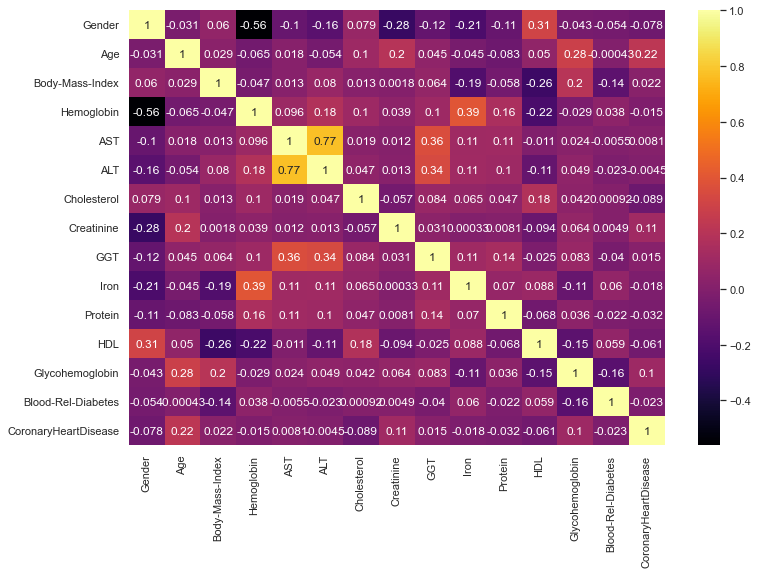

In [147]:

plt.subplots(figsize=(12,8))
sns.heatmap(data.corr(),cmap='inferno', annot=True)

# Ouliers detection and removal

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(1, 0, 'Gender'),
  Text(2, 0, 'Age'),
  Text(3, 0, 'Body-Mass-Index'),
  Text(4, 0, 'Hemoglobin'),
  Text(5, 0, 'AST'),
  Text(6, 0, 'ALT'),
  Text(7, 0, 'Cholesterol'),
  Text(8, 0, 'Creatinine'),
  Text(9, 0, 'GGT'),
  Text(10, 0, 'Iron'),
  Text(11, 0, 'Protein'),
  Text(12, 0, 'HDL'),
  Text(13, 0, 'Glycohemoglobin'),
  Text(14, 0, 'Blood-Rel-Diabetes'),
  Text(15, 0, 'CoronaryHeartDisease')])

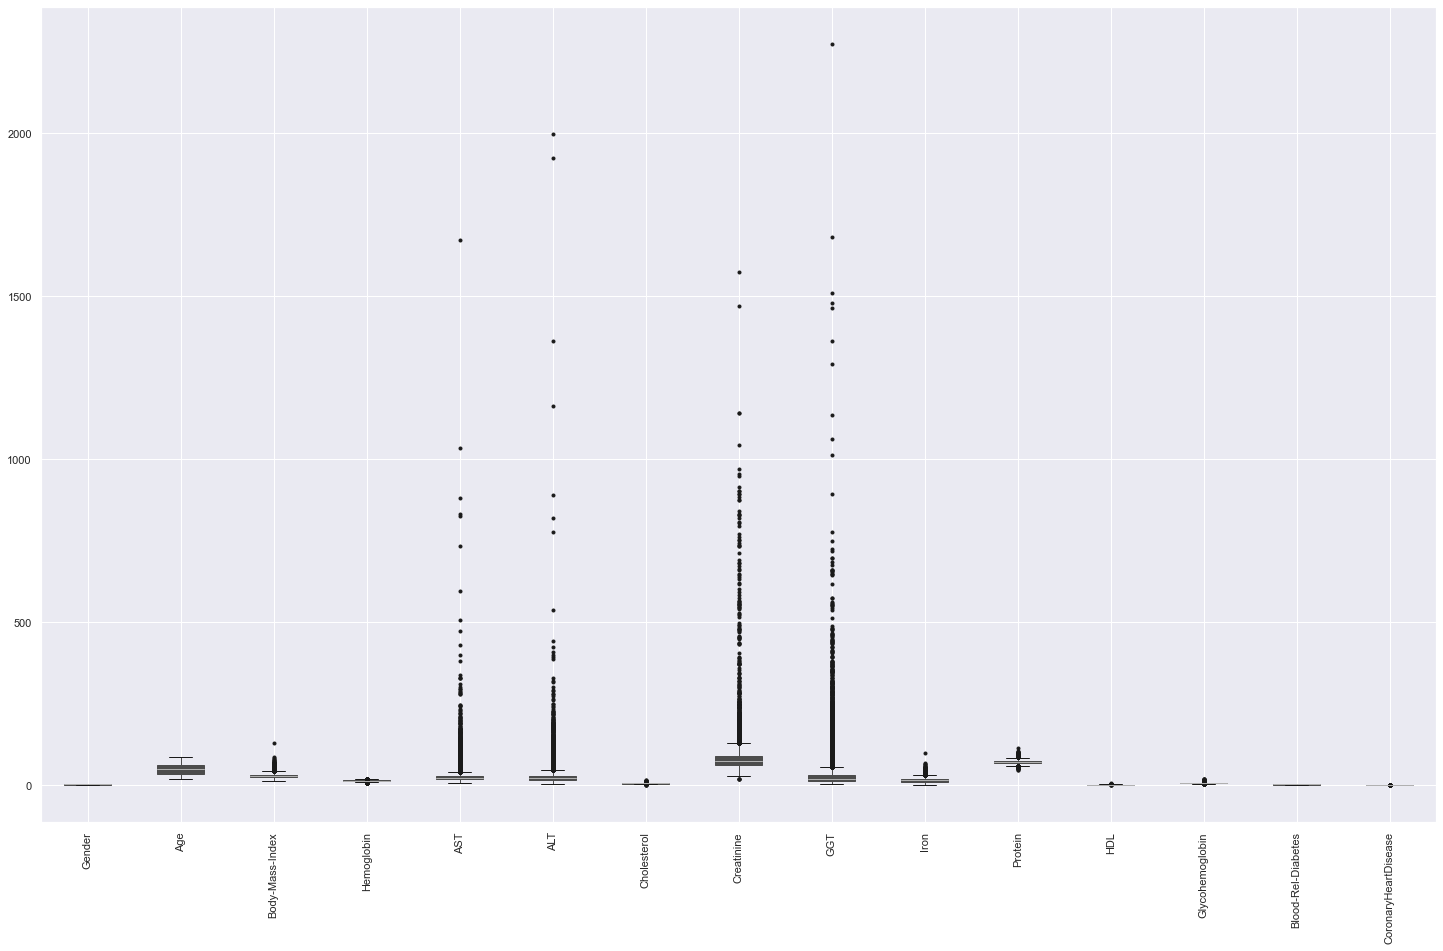

In [148]:
plt.subplots(figsize=(25,15))
data.boxplot(patch_artist=True, sym="k.")
plt.xticks(rotation=90)

In [149]:
minimum = 0
maximum = 0

def detect_outlier(feature):
    first_q = np.percentile(feature, 25)
    third_q = np.percentile(feature, 75) 
    IQR = third_q - first_q
    IQR *= 1.5
    minimum = first_q - IQR 
    maximum = third_q + IQR
    flag = False
    
    if(minimum > np.min(feature)):
        flag = True
    if(maximum < np.max(feature)):
        flag = True
    
    return flag

In [150]:
#function to remove outliers

def  remove_outlier(feature):
    first_q = np.percentile(X[feature], 25)
    third_q = np.percentile(X[feature], 75)
    IQR = third_q - first_q
    IQR *= 1.5
    
    minimum = first_q - IQR # the acceptable minimum value
    maximum = third_q + IQR # the acceptable maximum value
    
    median = X[feature].median()
    
    """
    # any value beyond the acceptance range are considered
    as outliers. 
    # we replace the outliers with the median value of that 
      feature.
    """
    
    X.loc[X[feature] < minimum, feature] = median 
    X.loc[X[feature] > maximum, feature] = median

# taking all the columns except the last one
# last column is the label

X = data.iloc[:, :-1]
for i in range(len(X.columns)): 
        remove_outlier(X.columns[i])

In [151]:
X = data.iloc[:, :-1]


In [152]:
#printing all features with outliers

for i in range(len(X.columns)):
    if(detect_outlier(X[X.columns[i]])):
        print(X.columns[i], "Contains Outlier")

Body-Mass-Index Contains Outlier
Hemoglobin Contains Outlier
AST Contains Outlier
ALT Contains Outlier
Cholesterol Contains Outlier
Creatinine Contains Outlier
GGT Contains Outlier
Iron Contains Outlier
Protein Contains Outlier
HDL Contains Outlier
Glycohemoglobin Contains Outlier


In [153]:
for i in range (50):
    for i in range(len(X.columns)):
        remove_outlier(X.columns[i])

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(1, 0, 'Gender'),
  Text(2, 0, 'Age'),
  Text(3, 0, 'Body-Mass-Index'),
  Text(4, 0, 'Hemoglobin'),
  Text(5, 0, 'AST'),
  Text(6, 0, 'ALT'),
  Text(7, 0, 'Cholesterol'),
  Text(8, 0, 'Creatinine'),
  Text(9, 0, 'GGT'),
  Text(10, 0, 'Iron'),
  Text(11, 0, 'Protein'),
  Text(12, 0, 'HDL'),
  Text(13, 0, 'Glycohemoglobin'),
  Text(14, 0, 'Blood-Rel-Diabetes')])

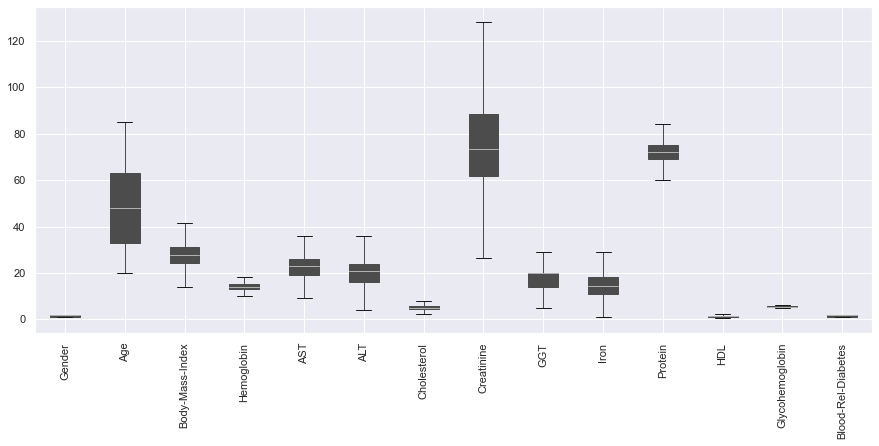

In [154]:
plt.subplots(figsize=(15,6))
X.boxplot(patch_artist=True, sym="k.")
plt.xticks(rotation=90)

In [155]:
for i in range(len(X.columns)):
    if(detect_outlier(X[X.columns[i]])):
        print(X.columns[i], "Contains Outlier")

In [156]:
#new dataframe with standardize features (by removing the mean and scaling to unit variance)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)
scaled_df = pd.DataFrame(data = scaled_data, columns = X.columns)
scaled_df.head()


Gender       Age  Body-Mass-Index  Hemoglobin       AST       ALT  \
0 -1.026927  1.557803        -0.594546   -0.057520 -0.790869 -0.762329   
1 -1.026927  0.003128         0.228165    0.220450 -0.174965  1.256736   
2 -1.026927 -0.663161         0.525908    1.262840 -1.201472  2.434524   
3 -1.026927  1.169134        -0.463304    1.818781  0.235638  2.434524   
4 -1.026927  1.779899        -0.118549    1.679795  0.030336 -0.425818   

   Cholesterol  Creatinine       GGT      Iron   Protein       HDL  \
0     0.224169   -0.716753  0.401809 -0.630587 -0.000498  0.177571   
1     2.155224   -0.233379  0.401809  1.813833  0.219406 -0.715435   
2    -1.140713    0.738864  0.401809 -0.630587 -0.000498 -1.003501   
3    -0.037686   -0.716753  1.186672 -0.464676 -1.319924 -0.139302   
4    -0.614980    0.738864  1.186672 -0.531040  1.538832 -0.830661   

   Glycohemoglobin  Blood-Rel-Diabetes  
0        -2.261760            0.905444  
1         0.338547            0.905444  
2        -0.636568           -1.104431  
3         0.013509           -1.104431  
4         1.313662            0.905444

In [158]:
label = data["CoronaryHeartDisease"]


In [159]:
encoder = LabelEncoder()
label = encoder.fit_transform(label)

In [160]:
X = scaled_df
y = label 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)

In [161]:
print(X_train.shape, y_test.shape)
print(y_train.shape, y_test.shape)

(29663, 14) (7416,)
(29663,) (7416,)


In [162]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

xnew2=SelectKBest(f_classif, k=(len(data.columns)-5)).fit_transform(X, y)  #choosing k=n-5 because it has to be a bit less than total number of features. Originally k=20 out of 25 features

In [163]:
 import sklearn.feature_selection as fs
 import matplotlib.pyplot as plt
 df2 = fs.SelectKBest(k='all')

 df2.fit(X, y)

 names = X.columns.values[df2.get_support()]

 scores = df2.scores_[df2.get_support()]

 names_scores = list(zip(names, scores))

 ns_df = pd.DataFrame(data = names_scores, columns=['Features','F_Scores'])

 ns_df_sorted = ns_df.sort_values(['F_Scores','Features'], ascending =[False, True])

 print('Feature importance based on their ANOVA F-score: \n', ns_df_sorted)

Feature importance based on their ANOVA F-score: 
               Features     F_Scores
1                  Age  1933.875317
7           Creatinine   471.491785
6          Cholesterol   345.708746
0               Gender   229.354021
12     Glycohemoglobin   211.668591
11                 HDL   146.078190
8                  GGT    67.405395
2      Body-Mass-Index    44.488460
10             Protein    38.769402
13  Blood-Rel-Diabetes    19.083169
4                  AST    17.049870
3           Hemoglobin     8.368635
9                 Iron     6.063885
5                  ALT     0.054089


In [164]:
#import statsmodels.api as sm
#import pandas
#from patsy import dmatrices
#logit_model = sm.OLS(y_train, X_train)
#result = logit_model.fit()
#print(result.summary2())

In [165]:
#np.exp(result.params)


In [166]:
#params = result.params
#conf = result.conf_int()
#conf['Odds Ratio'] = params.sort_index()
#conf.columns = ['5%', '95%', 'Odds Ratio']
#print(np.exp(conf))

In [167]:
#result.pvalues.sort_values()


In [168]:
#from sklearn.utils import class_weight
#class_weights = class_weight.compute_class_weight('balanced',
                                                # np.unique(y_train),
                                                # y_train)
#model.fit(X_train, y_train, class_weight=class_weights)


Best parameters : {'class_weight': {0: 0.6657894736842105, 1: 0.3342105263157895}}


<AxesSubplot:xlabel='weight'>

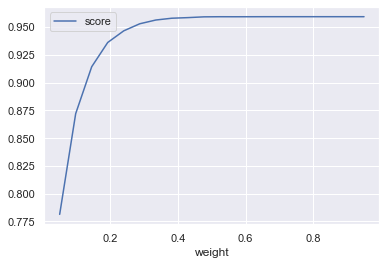

In [169]:
from sklearn.model_selection import GridSearchCV

weights = np.linspace(0.05, 0.95, 20)

gsc = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='accuracy',
    cv=15
)
grid_result = gsc.fit(X, y)

print("Best parameters : %s" % grid_result.best_params_)

# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
dataz.plot(x='weight')

In [170]:
class_weight = {0: 0.5236842105263158,
                1: 0.47631578947368425}

LR

In [171]:
'''
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_decision_regions, plot_confusion_matrix
from matplotlib import pyplot as plt
lr = LogisticRegression(class_weight='balanced',random_state=420)

# Fit..
lr.fit(X_train, y_train)

# Predict..
y_pred = lr.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
plot_confusion_matrix(confusion_matrix(y_test, y_pred))
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc
'''

"\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.metrics import confusion_matrix, classification_report\nfrom mlxtend.plotting import plot_decision_regions, plot_confusion_matrix\nfrom matplotlib import pyplot as plt\nlr = LogisticRegression(class_weight='balanced',random_state=420)\n\n# Fit..\nlr.fit(X_train, y_train)\n\n# Predict..\ny_pred = lr.predict(X_test)\n\n# Evaluate the model\nprint(classification_report(y_test, y_pred))\nplot_confusion_matrix(confusion_matrix(y_test, y_pred))\nfrom sklearn.metrics import roc_curve, auc\nfalse_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)\nroc_auc = auc(false_positive_rate, true_positive_rate)\nroc_auc\n"

In [172]:
'''
from sklearn.svm import SVC

clf_svc_rbf = SVC(kernel="rbf",class_weight='balanced',random_state=4200)
clf_svc_rbf.fit(X_train,y_train)
y_pred_clf_svc_rbf = clf_svc_rbf.predict(X_test)


import matplotlib.pyplot as plt
cm = confusion_matrix(y_test,y_pred_clf_svc_rbf)

#plt.figure(figsize=(5,5))
#sns.heatmap(cm,annot=True)
#plt.show()

#print(classification_report(y_test,y_pred_clf_svc_rbf))

print(classification_report(y_test, y_pred_clf_svc_rbf))
plot_confusion_matrix(confusion_matrix(y_test, y_pred_clf_svc_rbf))

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_clf_svc_rbf)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc
'''

'\nfrom sklearn.svm import SVC\n\nclf_svc_rbf = SVC(kernel="rbf",class_weight=\'balanced\',random_state=4200)\nclf_svc_rbf.fit(X_train,y_train)\ny_pred_clf_svc_rbf = clf_svc_rbf.predict(X_test)\n\n\nimport matplotlib.pyplot as plt\ncm = confusion_matrix(y_test,y_pred_clf_svc_rbf)\n\n#plt.figure(figsize=(5,5))\n#sns.heatmap(cm,annot=True)\n#plt.show()\n\n#print(classification_report(y_test,y_pred_clf_svc_rbf))\n\nprint(classification_report(y_test, y_pred_clf_svc_rbf))\nplot_confusion_matrix(confusion_matrix(y_test, y_pred_clf_svc_rbf))\n\nfrom sklearn.metrics import roc_curve, auc\nfalse_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_clf_svc_rbf)\nroc_auc = auc(false_positive_rate, true_positive_rate)\nroc_auc\n'

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      7121
           1       0.33      0.00      0.01       295

    accuracy                           0.96      7416
   macro avg       0.65      0.50      0.49      7416
weighted avg       0.94      0.96      0.94      7416



0.5015544855393096

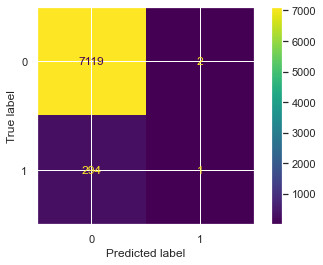

In [173]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

rd = RandomForestClassifier(class_weight='balanced',random_state=4200)
rd.fit(X_train,y_train)
y_pred_rd = rd.predict(X_test)


import matplotlib.pyplot as plt
cm = confusion_matrix(y_test,y_pred_rd)

#plt.figure(figsize=(5,5))
#sns.heatmap(cm,annot=True,linewidths=.3)
#plt.show()

print(classification_report(y_test,y_pred_rd))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred_rd)  #added by Elena because of confusion matrix error 


from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_rd)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc


In [174]:
#CV appraoach

# Methods

## SVM (Support Vector Machine)

In [175]:

# evaluate a logistic regression model using k-fold cross-validation
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

from sklearn.linear_model import LogisticRegression
# create dataset
#X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
# prepare the cross-validation procedure
#cv = KFold(n_splits=5, test_size= 0.2, random_state=0)
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
# create model
model = SVC(kernel='rbf', C=1, class_weight=class_weight)
# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.4f (%.4f)' % (mean(scores), std(scores)))
scores

Accuracy: 0.9596 (0.0023)


array([0.95833333, 0.95765912, 0.95617584, 0.96156958, 0.96197411,
       0.96183927, 0.95779396, 0.96089536, 0.95738943, 0.96264833])

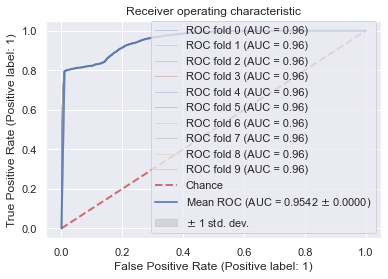

In [176]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold



# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
classifier = svm.SVC(kernel='rbf', probability=True, class_weight=class_weight,
                     random_state=42)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X, y)
    viz = plot_roc_curve(classifier, X, y,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic")
ax.legend(loc="lower right")
plt.show()




In [177]:
#confusion matrix (added by Elena)
# conf_matrix = confusion_matrix(y_test, y_pred)

# # Print the confusion matrix using Matplotlib
# #
# fig, ax = plt.subplots(figsize=(5, 5))
# ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
# for i in range(conf_matrix.shape[0]):
#     for j in range(conf_matrix.shape[1]):
#         ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
# plt.xlabel('Predictions', fontsize=18)
# plt.ylabel('Actuals', fontsize=18)
# plt.title('Confusion Matrix', fontsize=18)
# plt.show()

# LR (Logistic Regression)

In [178]:
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

from sklearn.linear_model import LogisticRegression
# create dataset
#X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
# prepare the cross-validation procedure
#cv = KFold(n_splits=5, test_size= 0.2, random_state=0)
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
# create model
model = LogisticRegression(class_weight=class_weight)
# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.4f (%.4f)' % (mean(scores), std(scores)))
scores

Accuracy: 0.9596 (0.0021)


array([0.95846818, 0.9579288 , 0.95617584, 0.96156958, 0.96197411,
       0.96156958, 0.9579288 , 0.96062567, 0.95725458, 0.9622438 ])

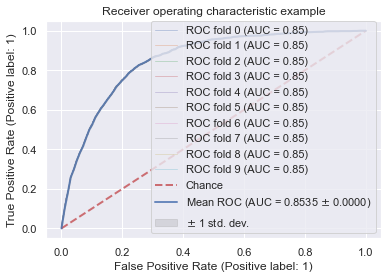

In [179]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

# #############################################################################
# Data IO and generation

# Import some data to play with
#iris = datasets.load_iris()
#X = iris.data
#y = iris.target
#X, y = X[y != 2], y[y != 2]
#n_samples, n_features = X.shape

# Add noisy features
#random_state = np.random.RandomState(0)
#X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
classifier = LogisticRegression(class_weight=class_weight,random_state=42)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X, y)
    viz = plot_roc_curve(classifier, X, y,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

In [180]:
# #confusion matrix (added by Elena)
# conf_matrix = confusion_matrix(y_test, y_pred)

# # Print the confusion matrix using Matplotlib
# #
# fig, ax = plt.subplots(figsize=(5, 5))
# ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
# for i in range(conf_matrix.shape[0]):
#     for j in range(conf_matrix.shape[1]):
#         ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
# plt.xlabel('Predictions', fontsize=18)
# plt.ylabel('Actuals', fontsize=18)
# plt.title('Confusion Matrix', fontsize=18)
# plt.show()

# RF (Random Forest)

In [181]:
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [182]:
# create dataset
#X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
# prepare the cross-validation procedure
#cv = KFold(n_splits=5, test_size= 0.2, random_state=0)
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
# create model
model = RandomForestClassifier(class_weight=class_weight)
# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.4f (%.4f)' % (mean(scores), std(scores)))
scores

Accuracy: 0.9596 (0.0022)


array([0.95819849, 0.95752427, 0.95617584, 0.96156958, 0.96183927,
       0.96170442, 0.9579288 , 0.96089536, 0.95752427, 0.96278317])

In [183]:
####-------------------------- Added code to evaluate feature importance

from sklearn.inspection import permutation_importance

# fit the model
model.fit(X_train,y_train)
# get importance
importance = model.feature_importances_  #size 17

In [184]:
#model.estimators_  #estimators

In [185]:
#features list
#cols= list(data.columns) 

In [186]:
# Sort the feature importance in descending order
sorted_indices = np.argsort(importance)[::-1]

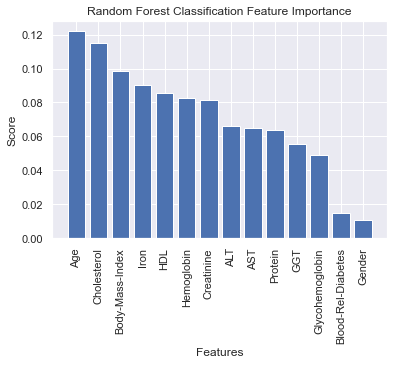

In [187]:
plt.title('Random Forest Classification Feature Importance')
plt.bar(range(X_train.shape[1]), importance[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
#plt.tight_layout() #no tight layout otherwise some values are missing
plt.xlabel('Features')
plt.ylabel('Score')
plt.show()

In [188]:
# #for loop to see the trees by text
# for i in range(len(model.estimators_)):
#     print(tree.export_text(model.estimators_[i]))

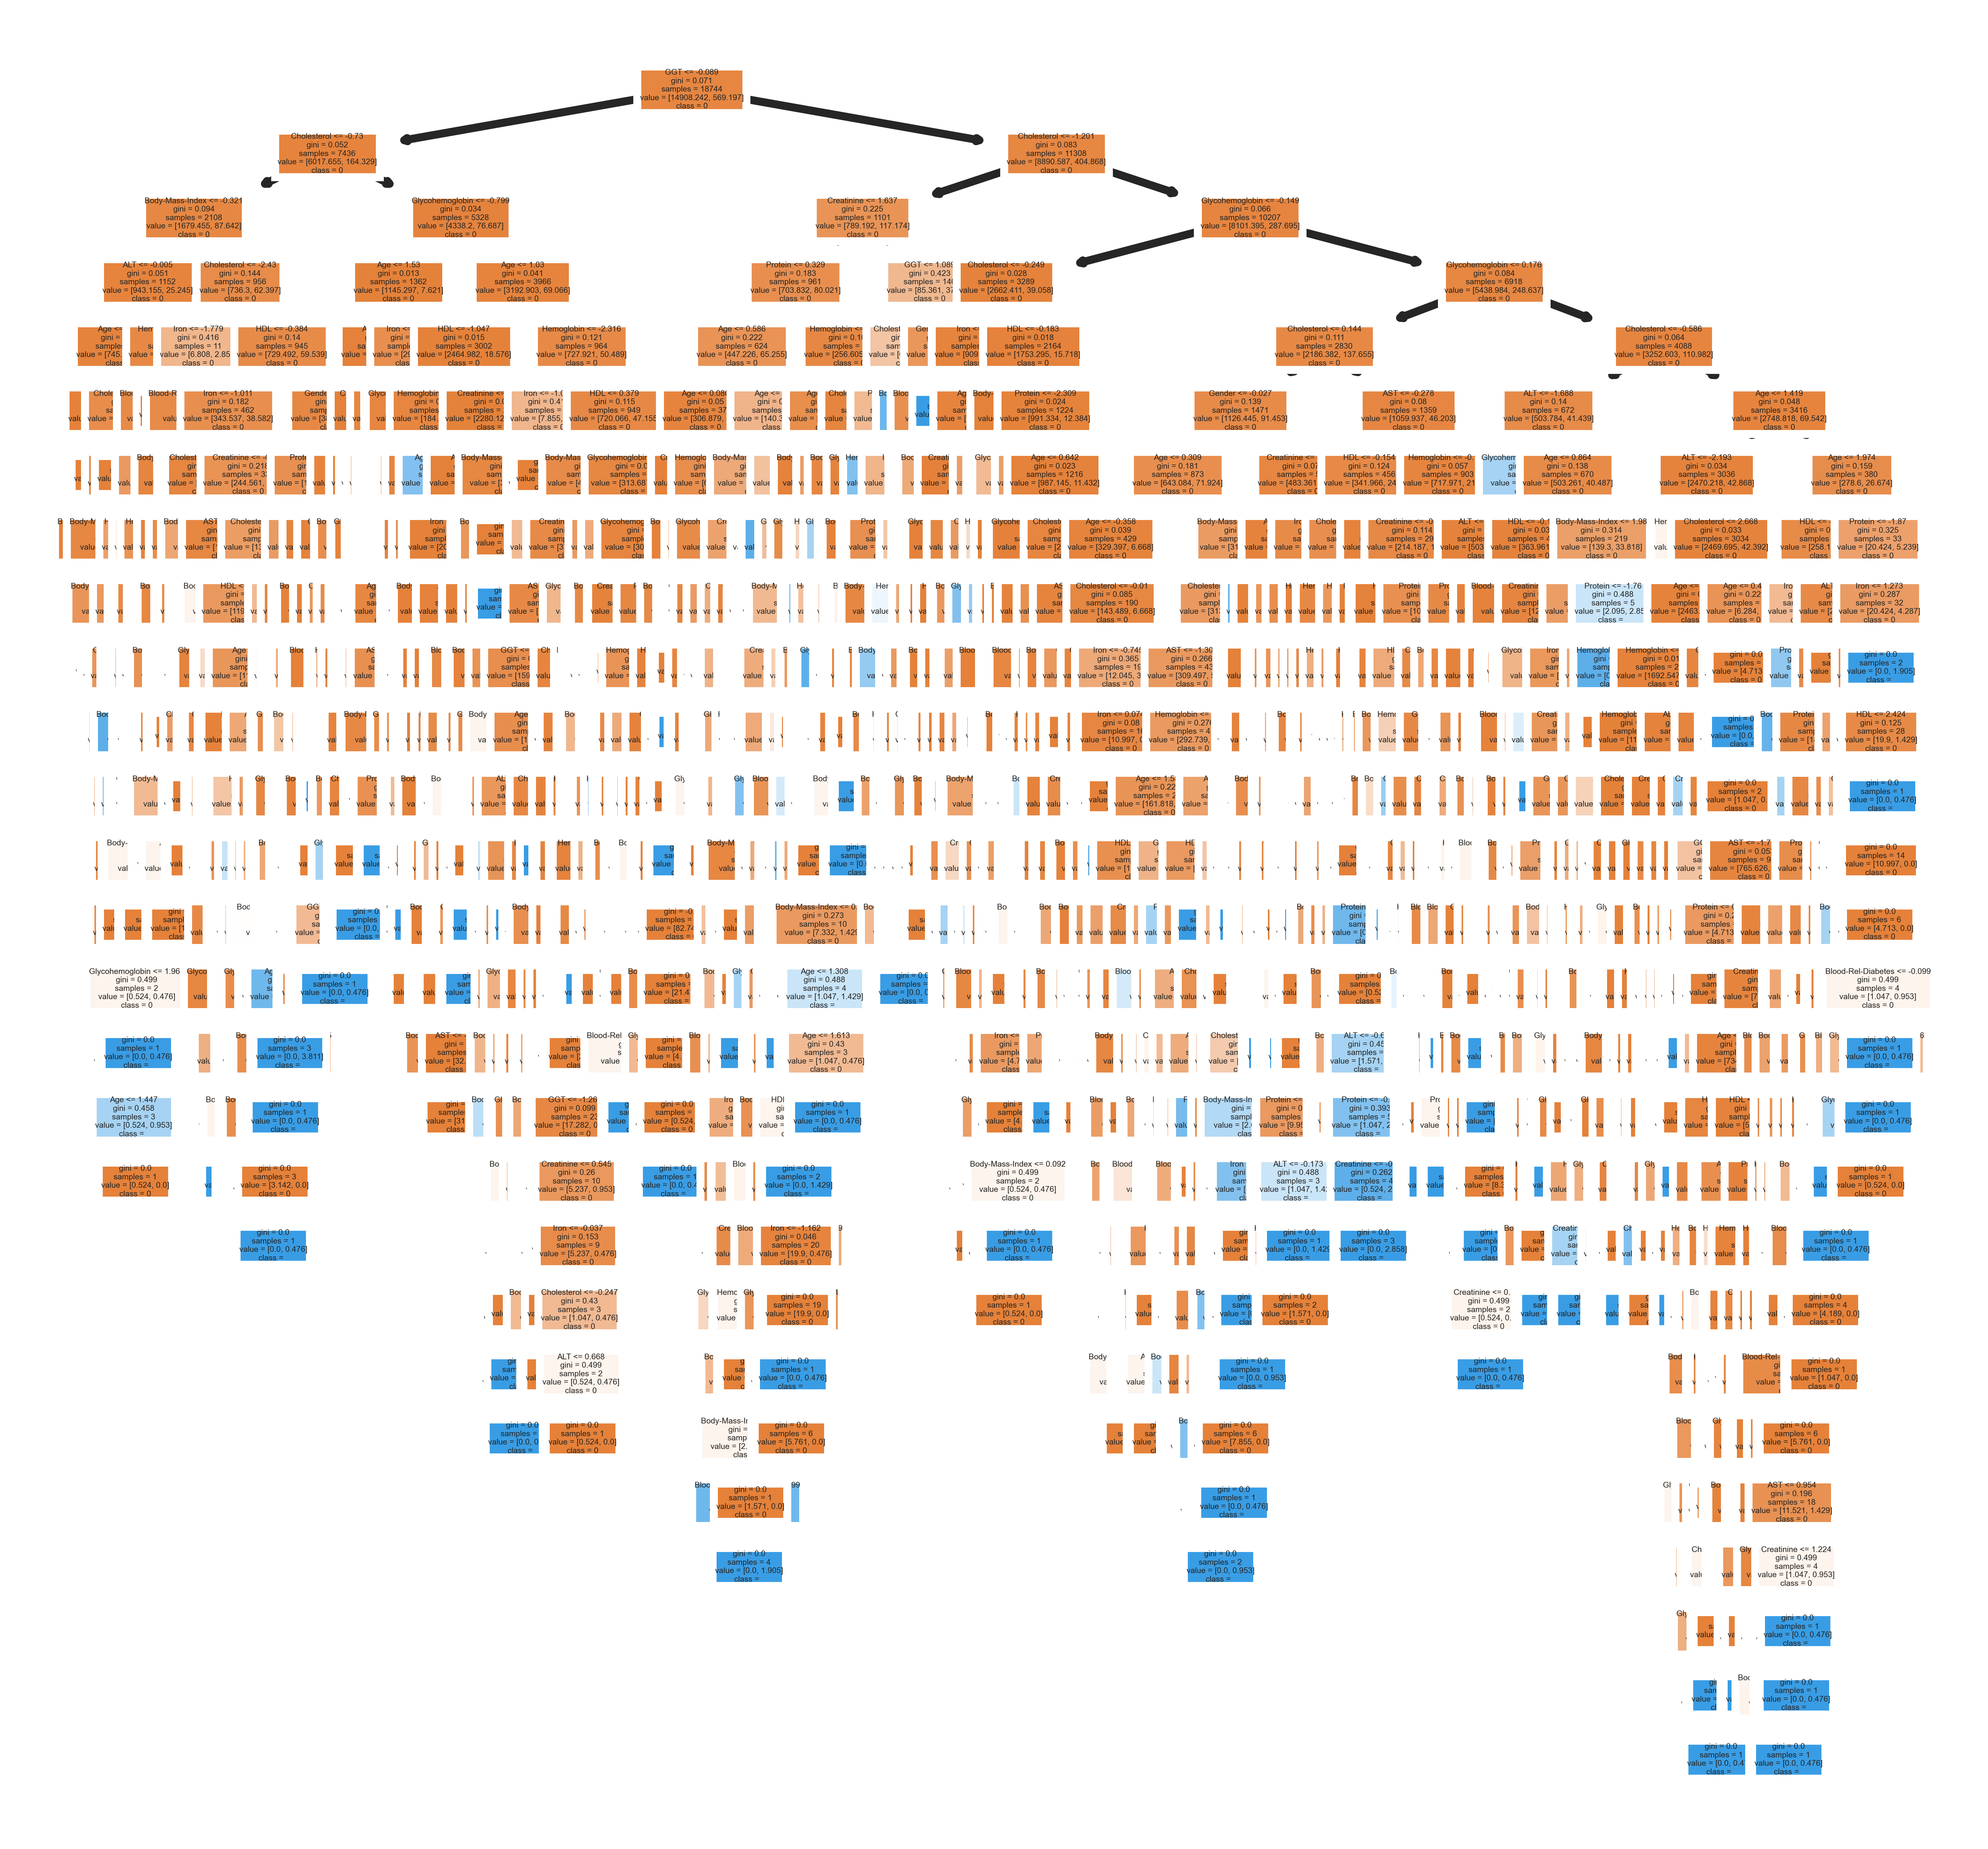

In [189]:
#generate tree trying a different way of plotting the first decision tree (with index 0 in the list) so certain values are more visible
fn=data.columns  
cn=str(data["CoronaryHeartDisease"])  #had to convert into string to avoid error
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=1800)  #tried dpi= 800, 1800
tree.plot_tree(model.estimators_[0],
               feature_names = fn, 
               class_names=cn,
               filled = True);
fig.savefig('rf00_individualtree.png')

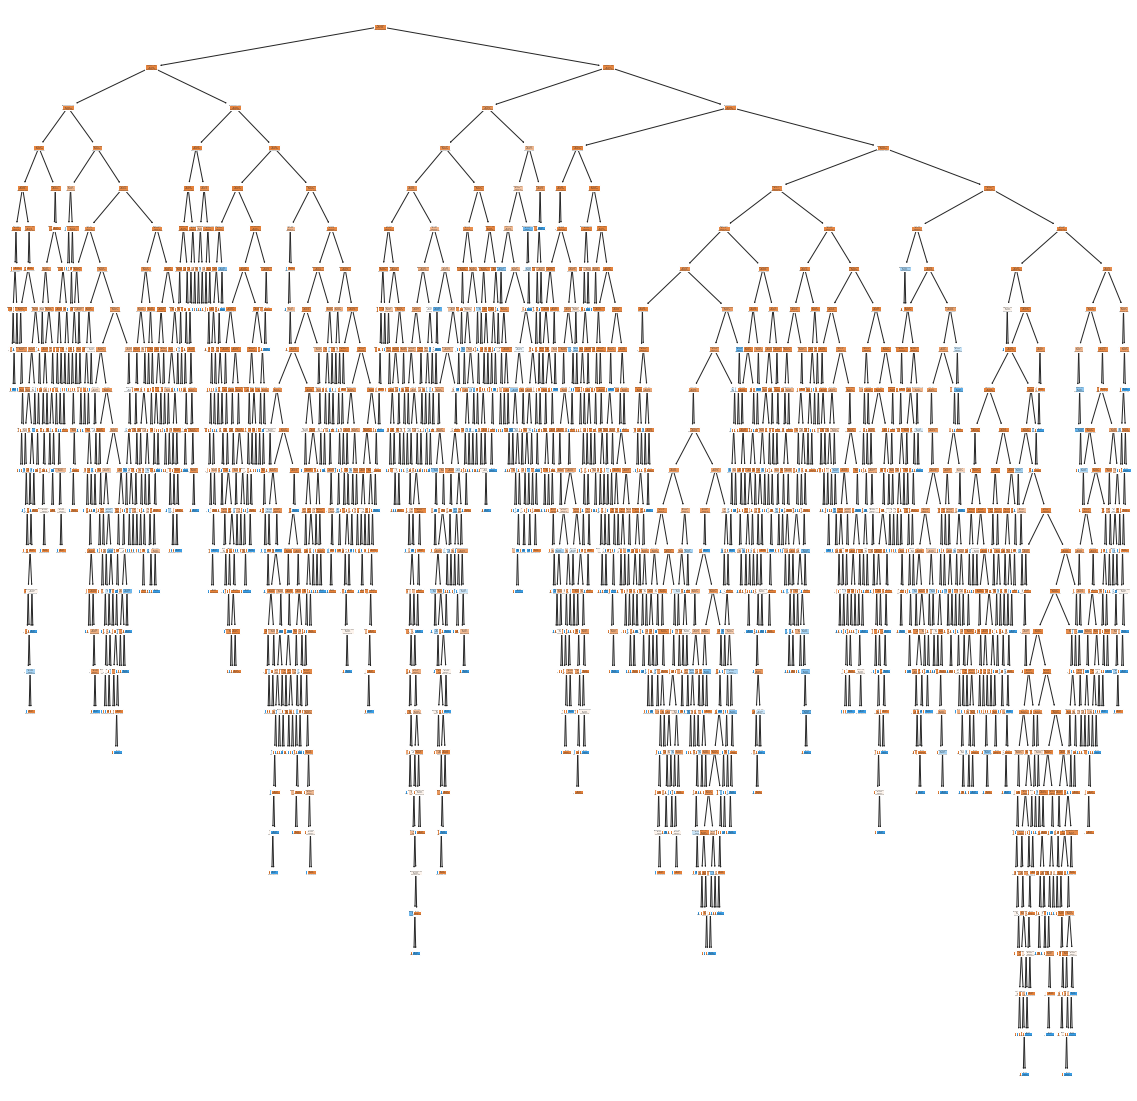

In [190]:
#generate tree
plt.figure(figsize=(20,20))
_ = tree.plot_tree(model.estimators_[0], feature_names=fn, filled=True)

In [191]:
#checking the depth of the first tree from RF
model.estimators_[0].tree_.max_depth   # outcome 29

26

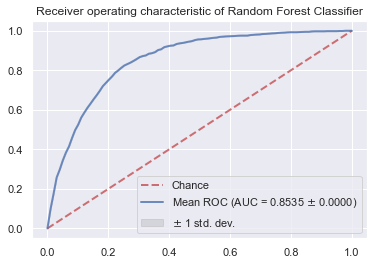

In [192]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

# #############################################################################
# Data IO and generation

# Import some data to play with
#iris = datasets.load_iris()
#X = iris.data
#y = iris.target
#X, y = X[y != 2], y[y != 2]
#n_samples, n_features = X.shape

# Add noisy features
#random_state = np.random.RandomState(0)
#X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
classifier = RandomForestClassifier(class_weight=class_weight,random_state=42)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X, y)
    #viz = plot_roc_curve(classifier, X, y,
                  #       name='ROC fold {}'.format(i),
                    #     alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic of Random Forest Classifier")
ax.legend(loc="lower right")
plt.show()

## DT (Decision Tree)

In [193]:
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.tree import DecisionTreeClassifier


# create dataset
#X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
# prepare the cross-validation procedure
#cv = KFold(n_splits=5, test_size= 0.2, random_state=0)
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
# create model
model = DecisionTreeClassifier(class_weight=class_weight)
# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.4f (%.4f)' % (mean(scores), std(scores)))
scores

Accuracy: 0.9230 (0.0031)


array([0.92448759, 0.92259978, 0.91788026, 0.92273463, 0.92354369,
       0.92893743, 0.92071197, 0.92003776, 0.92206041, 0.92677994])

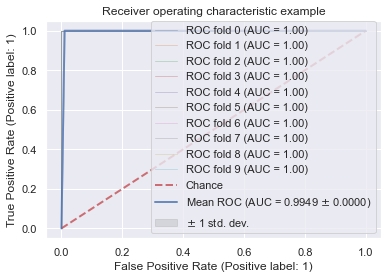

In [194]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

# #############################################################################
# Data IO and generation

# Import some data to play with
#iris = datasets.load_iris()
#X = iris.data
#y = iris.target
#X, y = X[y != 2], y[y != 2]
#n_samples, n_features = X.shape

# Add noisy features
#random_state = np.random.RandomState(0)
#X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
classifier = DecisionTreeClassifier(class_weight=class_weight,random_state=42)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X, y)
    viz = plot_roc_curve(classifier, X, y,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

In [195]:
# from sklearn.model_selection import cross_val_score
# from sklearn import svm
# clf = svm.SVC(kernel='rbf', C=1, class_weight=class_weight)
# scores = cross_val_score(clf, X, y, cv=5)
# print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

# clf.score(X_test, y_test)

## ANN (Artificial Neural Network)

In [196]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout

In [197]:
classifier=Sequential()
classifier.add(Dense(units=256, kernel_initializer='uniform',activation='relu',input_dim=(len(data.columns)-1)))  #changed to length-1 so there is no need to change it everytime we change number of attributes
classifier.add(Dense(units=128, kernel_initializer='uniform',activation='relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(units=64, kernel_initializer='uniform',activation='relu'))
classifier.add(Dropout(0.4))
classifier.add(Dense(units=32, kernel_initializer='uniform',activation='relu'))

classifier.add(Dense(units=1, kernel_initializer='uniform',activation='sigmoid'))
classifier.compile(optimizer='adam',loss="binary_crossentropy",metrics=['accuracy'])
classifier.fit(X_train,y_train,batch_size=10,epochs=100,class_weight=class_weight,validation_data=(X_test, y_test))

Epoch 1/100
2967/2967 [==============================] - 8s 2ms/step - loss: 0.0746 - accuracy: 0.9590 - val_loss: 0.1378 - val_accuracy: 0.9602
Epoch 2/100
2967/2967 [==============================] - 7s 2ms/step - loss: 0.0688 - accuracy: 0.9591 - val_loss: 0.1411 - val_accuracy: 0.9602
Epoch 3/100
2967/2967 [==============================] - 7s 2ms/step - loss: 0.0684 - accuracy: 0.9591 - val_loss: 0.1401 - val_accuracy: 0.9602
Epoch 4/100
2967/2967 [==============================] - 7s 2ms/step - loss: 0.0682 - accuracy: 0.9591 - val_loss: 0.1395 - val_accuracy: 0.9602
Epoch 5/100
2967/2967 [==============================] - 7s 2ms/step - loss: 0.0672 - accuracy: 0.9591 - val_loss: 0.1395 - val_accuracy: 0.9602
Epoch 6/100
2967/2967 [==============================] - 7s 2ms/step - loss: 0.0665 - accuracy: 0.9591 - val_loss: 0.1389 - val_accuracy: 0.9602
Epoch 7/100
2967/2967 [==============================] - 7s 2ms/step - loss: 0.0659 - accuracy: 0.9591 - val_loss: 0.1362 - val_ac

In [198]:
#clf_svc_rbf.fit(X_train,y_train)
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,auc,f1_score
y_pred = classifier.predict(X_test)>0.9


import matplotlib.pyplot as plt
cm = confusion_matrix(y_test,y_pred)

#plt.figure(figsize=(5,5))
#sns.heatmap(cm,annot=True)
#plt.show()

#print(classification_report(y_test,y_pred_clf_svc_rbf))

print(classification_report(y_test, y_pred))
#plot_confusion_matrix(confusion_matrix(y_test, y_pred))

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

232/232 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      7121
           1       0.25      0.00      0.01       295

    accuracy                           0.96      7416
   macro avg       0.61      0.50      0.49      7416
weighted avg       0.93      0.96      0.94      7416



0.5014842706818458

AUC Score: 0.5014842706818458


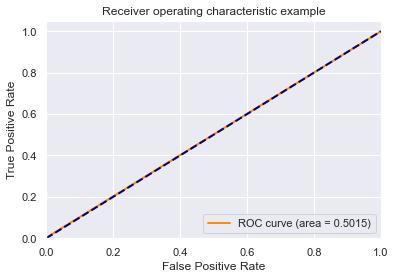

In [199]:
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import auc

fpr , tpr , thresholds = roc_curve ( y_test , y_pred)
auc_keras = auc(fpr, tpr)
print("AUC Score:",auc_keras)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % auc_keras)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [200]:
#from sklearn.tree import DecisionTreeClassifier


#from sklearn.model_selection import cross_val_score

#dt = DecisionTreeClassifier(class_weight=class_weight)
#scores = cross_val_score(clf, X, y, cv=5)
#print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))

In [201]:
'''

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,auc,f1_score

lr = LogisticRegression()
lr.fit(X_train,y_train)
y_pred_logistic = lr.predict(X_test)

import matplotlib.pyplot as plt
cm = confusion_matrix(y_test,y_pred_logistic)

plt.figure(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidths=.3)
plt.show()

print(classification_report(y_test,y_pred_logistic))


from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_logistic)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc
print(f1_score(y_test, y_pred_logistic,average="macro"))
'''

'\n\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,auc,f1_score\n\nlr = LogisticRegression()\nlr.fit(X_train,y_train)\ny_pred_logistic = lr.predict(X_test)\n\nimport matplotlib.pyplot as plt\ncm = confusion_matrix(y_test,y_pred_logistic)\n\nplt.figure(figsize=(5,5))\nsns.heatmap(cm,annot=True,linewidths=.3)\nplt.show()\n\nprint(classification_report(y_test,y_pred_logistic))\n\n\nfrom sklearn.metrics import roc_curve, auc\nfalse_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_logistic)\nroc_auc = auc(false_positive_rate, true_positive_rate)\nroc_auc\nprint(f1_score(y_test, y_pred_logistic,average="macro"))\n'

# Ensemble
To combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator.

In [202]:
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

In [203]:
clf1 = SVC(kernel='rbf', C=1, class_weight=class_weight,random_state=42)
clf2 = LogisticRegression(class_weight=class_weight,random_state=42)
clf3 = RandomForestClassifier(class_weight=class_weight,random_state=42)
clf4 = DecisionTreeClassifier(class_weight=class_weight,random_state=42)
#clf5 = Sequential()

In [204]:
eclf = VotingClassifier( estimators=[('svm', clf1), ('lr', clf2), ('rf', clf3), ('dt',clf4)],
     voting='hard')

# Additional code

In [205]:
acc_score_list=[]
for clf, label in zip([clf1, clf2, clf3,clf4 ,eclf], ['SVM', 'LR', 'RF','DT', 'Ensemble']):
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=10)
    acc_score_list.append("%0.4f (+/- %0.4f)" % (scores.mean(), scores.std()))
scores
print("Accuracy:", acc_score_list)

Accuracy: ['0.9593 (+/- 0.0001)', '0.9593 (+/- 0.0002)', '0.9593 (+/- 0.0002)', '0.9213 (+/- 0.0043)', '0.9593 (+/- 0.0001)']


In [206]:
#adding nice table for comparative purposes 

import plotly.graph_objects as go
paper_accuracy=[0.89, 0.88, 0.90, 0.86, 0.90]  #taken from the paper diabetic study, table II
accuracy_25_list= ['0.8738 (+/- 0.0016)', '0.8691 (+/- 0.0031)', '0.8909 (+/- 0.0047)', '0.8400 (+/- 0.0068)', '0.8846 (+/- 0.0046)']  #taken from paper author repository 
method_list= ['SVM', 'LR', 'RF','DT', 'Ensemble']
trace= go.Table(header=dict(values=['Method', 'Paper accuracy (25 features)','Accuracy (25 features)', 'Accuracy (%d features)' %(len(data.columns))]),
                cells=dict(values=[method_list, paper_accuracy, accuracy_25_list, acc_score_list]))
mylayout=dict(title='Accuracy comparison table', autosize=False)
fig = go.Figure(data=[trace], layout=mylayout)
fig.show()


In [207]:
#calculate F1 score
f1_score_list=[]
for clf, label in zip([clf1, clf2, clf3,clf4 ,eclf], ['SVM', 'LR', 'RF','DT', 'Ensemble']):
    scores = cross_val_score(clf, X, y, scoring='f1', cv=10)
    f1_score_list.append("%0.4f (+/- %0.4f)" % (scores.mean(), scores.std()))
scores
print("F1:", f1_score_list)



F1: ['0.0000 (+/- 0.0000)', '0.0052 (+/- 0.0087)', '0.0039 (+/- 0.0083)', '0.1480 (+/- 0.0280)', '0.0000 (+/- 0.0000)']


In [208]:

#table with accuracy and f1
trace= go.Table(header=dict(values=['Method','Accuracy (%d features)' %(len(data.columns)), 'F1 score (%d features)' %(len(data.columns))]),
                cells=dict(values=[method_list, acc_score_list, f1_score_list]))
mylayout=dict(title='Accuracy and F1 score table', autosize=False)
fig = go.Figure(data=[trace], layout=mylayout)
fig.show()

In [209]:
#cloning lists and sorting them to have a sorted table
sort_acc_score_list = sorted(acc_score_list)
sort_f1_score_list = sorted(f1_score_list)
sort_method_list = ['DT', 'LR', 'SVM', 'Ensemble', 'RF']  #manually sorting this list, according to previous table
trace= go.Table(header=dict(values=['Method','Accuracy (%d features)' %(len(data.columns)), 'F1 score (%d features)' %(len(data.columns))]),
                cells=dict(values=[sort_method_list, sort_acc_score_list, sort_f1_score_list]))
mylayout=dict(title='Accuracy and F1 score table (sorted)', autosize=False)
fig = go.Figure(data=[trace], layout=mylayout)
fig.show()